<a href="https://colab.research.google.com/github/Lyshen/PiggyToy/blob/main/Lesson01_SelfSimpleDNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Lesson 1**. Simple DNN excercise

## Design an easy and visual implement excercise for kids

1.Learn to use matplotlib to display data

2.Design a easy classification question

3.Learn to implement a simple Neural Network  (parameters, matrix, active function)

4.Learn to implement a simple Back progragation (gradient descent , loss function, batch operation)

5.Compare self-implement NN with pytorch's NN, specially the effective


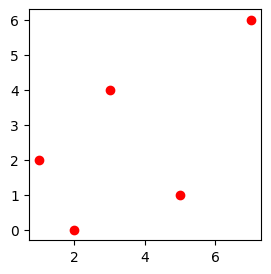

In [2]:
import matplotlib.pyplot as plt
import numpy as np

x = np.array([1, 3, 5, 7, 2])
y = np.array([2, 4, 1, 6, 0])

plt.figure(figsize=(3,3))
plt.scatter(x, y, marker='o', c='r')
plt.show()

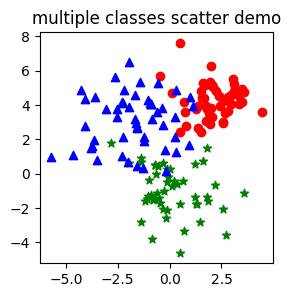

In [3]:
# Generate serveral normal subsample datasets and scatter them on the figure
size_of_class = 3
size_of_sample = 50
means = [(2,4), (0,-1), (-2,3)]
vars = [[[1,0], [0,1]], [[2,0], [0,2]], [[3,0],[0,3]]]
markers = ['o', '*', '^']
colors = ['r', 'g', 'b']

samples = []
for i in range(size_of_class):
    samples.append(np.random.multivariate_normal(means[i], vars[i], size_of_sample))

plt.figure(figsize=(3,3))
for i in range(size_of_class):
    x, y = samples[i].T
    plt.scatter(x, y, marker=markers[i], c=colors[i])
plt.title('multiple classes scatter demo')
plt.show()

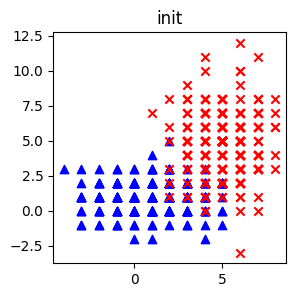

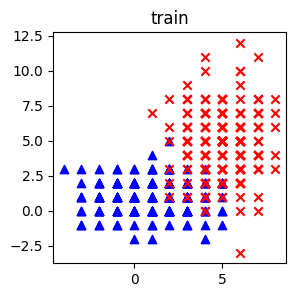

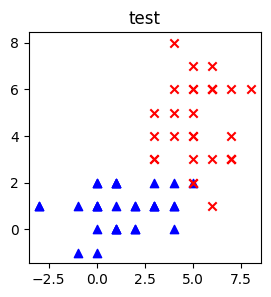

In [4]:
# Random generation of two kinds of entity and try to split them up into train dataset and test dataset.
def plot_features_and_labels(features, l, markers, colors, title):
    plt.figure(figsize=(3,3))
    for i in range(2):
        x = features[0, np.where(l[i, :] == 1)]
        y = features[1, np.where(l[i, :] == 1)]
        plt.scatter(x, y, marker=markers[i], c=colors[i])
    plt.title(title)
    plt.show()

def split_train_and_test_data(feature_matrix, label_matrix, split_rate = 0.9):
    m = feature_matrix.shape[1]
    indices = np.array(range(m))
    np.random.shuffle(indices)

    split_index = int(m * split_rate)
    train_indices = indices[0:split_index]
    test_indices = indices[split_index:]

    train_features = feature_matrix[:, np.array(train_indices)]
    train_labels = label_matrix[:, np.array(train_indices)]

    test_features = feature_matrix[:, np.array(test_indices)]
    test_labels = label_matrix[:, np.array(test_indices)]

    return train_features, train_labels, test_features, test_labels

size_of_class = 2
size_of_sample = 300
size_of_feature = 2
means = [(1,1), (5,5)]
vars = [[[4, 0], [0,1]], [[2,0], [0,5]]]
markers = ['^', 'x']
colors = ['b', 'r']

features = []
labels = []
for i in range(size_of_class):
    sample = np.round(np.random.multivariate_normal(means[i], vars[i], size_of_sample))
    for j in range(size_of_sample):
        label = np.zeros((size_of_class, 1))
        label[i, 0] = 1
        labels.append(label)
    features.append(sample.T)

features = np.concatenate(features, axis=1)
features.reshape((size_of_feature, size_of_sample * size_of_class))
labels = np.concatenate(labels, axis=1)
labels.reshape((size_of_class, size_of_sample * size_of_class))

train_features, train_labels, test_features, test_labels = split_train_and_test_data(features, labels)

plot_features_and_labels(features, labels, markers, colors, 'init')
plot_features_and_labels(train_features, train_labels, markers, colors, 'train')
plot_features_and_labels(test_features, test_labels, markers, colors, 'test')

In [5]:
# Implement yourself DNN
sigmod = lambda a: 1.0 / (1.0 + np.exp(-a))

class Neuron:
    def __init__(self, feature_size, active_function=sigmod):
        self.n = feature_size
        #self.W = np.random.rand(self.n + 1, 1) # W[n, 1] 、 bias
        self.W = np.random.uniform(-1., 1., size=(self.n + 1, 1))
        self.learning_rate = 0.01
        self.active_func = active_function

        self.X = None
        self.z = None  # z = W^T * x  ; X.shape(n+1, 1) W.shape(x+1, 1)
        self.H = None  # h = sigmod(z)

    def forward(self, x):
        m = x.shape[1]
        bais = np.ones((1, m))
        self.X = np.concatenate((x, bais), axis=0)
        self.z = self.W.T.dot(self.X)
        self.H = self.active_func(self.z)
        return self.H
    
    def backward(self, dL_by_dH):
        I = np.ones(self.H.shape)
        dH_by_dZ = (I - self.H) * self.H   # deveriate of sigmod function
        dZ_by_dW = self.X

        m = dL_by_dH.shape[1]
        a = dL_by_dH * dH_by_dZ
        a = np.ones((3, 1)).dot(a)
        dL_by_dW = a * dZ_by_dW / m

        return dL_by_dW

    def predict(self, X):
        m = X.shape[1]
        bias = np.ones((1, m))
        x = np.concatenate((X, bias), axis=0)
        z = self.W.T.dot(x)
        score = self.active_func(z)
        return score

    def update_parameters(self, dL_by_dW, i):
        x = dL_by_dW[:, i].reshape((3,1))
        self.W = self.W - self.learning_rate * x


binary_classification = lambda a: np.array([a, 1.0 - a])
class OutputLayer:
    def __init__(self, size_of_class):
        self.c = size_of_class
        self.output_func = binary_classification
        self.loss = 0.
        self.dL_by_dH = None
    
    def forward(self, s, Y):
        m = s.shape[1]
        y_hat = self.output_func(s).reshape((self.c, m))
        log_y_hat = np.log(y_hat, where= y_hat != 0)
        yy = Y * log_y_hat
        KL_matrix = np.ones((1, self.c)).dot(yy)
        self.loss = -1. * np.sum(KL_matrix)

        kk = np.divide(Y, y_hat, out=np.zeros_like(Y), where=y_hat!=0)
        self.dL_by_dH = (kk[0, :] + kk[1, :]).reshape((1, m))
        return y_hat, self.loss

    def backward(self):
        return self.dL_by_dH


def draw_neuron_boundary(neuron, features, labels, markers, colors):
    # Define the grid of points
    grid_step = 0.5
    xx, yy = np.meshgrid(np.arange(-4, 10, grid_step), np.arange(-4, 10, grid_step))
    grid_points = np.c_[xx.ravel(), yy.ravel()].T

    # Predict
    predict = neuron.predict(grid_points)

    # Create the scatter plot with decision boundary
    positive_index = np.where(predict[0,:] > 0.5)
    negative_index = np.where(predict[0,:] <= 0.5)

    plt.figure(figsize=(4, 4))
    plt.scatter(grid_points[0, positive_index], grid_points[1, positive_index], c='b', alpha=0.3)
    plt.scatter(grid_points[0, negative_index], grid_points[1, negative_index], c='y', alpha=0.3)

    for i in range(2):
        x = features[0, np.where(labels[i, :] == 1)]
        y = features[1, np.where(labels[i, :] == 1)]
        plt.scatter(x, y, marker=markers[i], c=colors[i])

    plt.show()

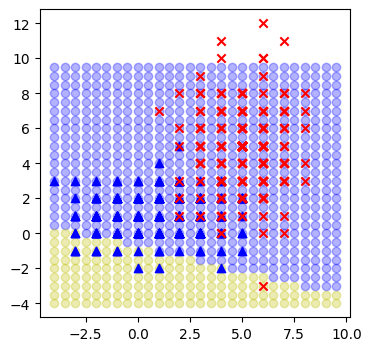

Epoch 1
-------------------------------
loss : 1801.6392828310986


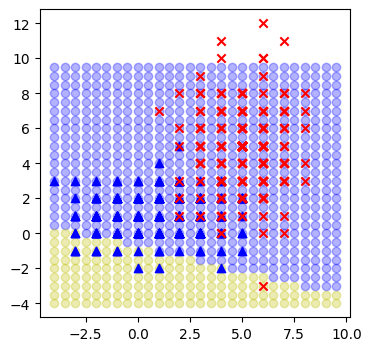

loss : 1737.3799182132393


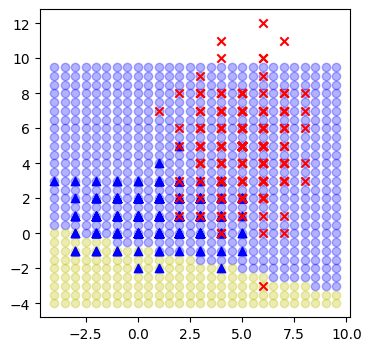

Epoch 2
-------------------------------
loss : 1737.1135968211424


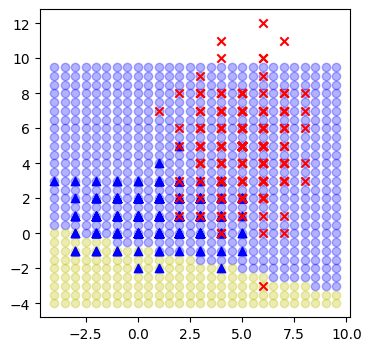

loss : 1673.0002532492329


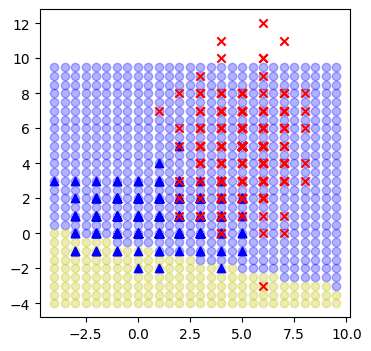

Epoch 3
-------------------------------
loss : 1672.7347863918553


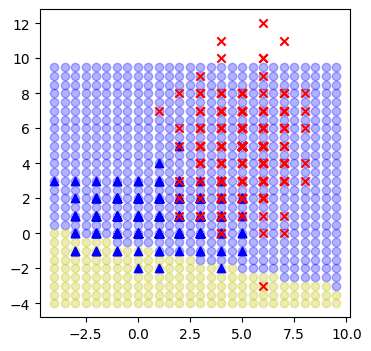

loss : 1608.795432001021


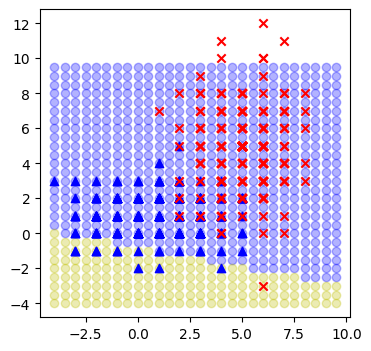

Epoch 4
-------------------------------
loss : 1608.5309330094292


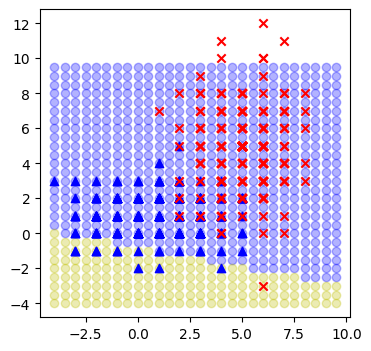

loss : 1544.799251013792


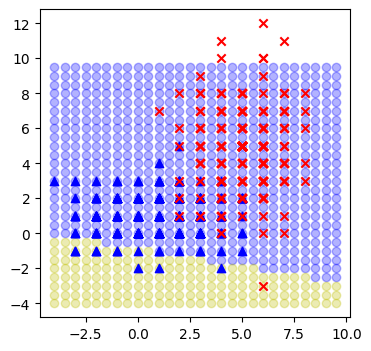

Epoch 5
-------------------------------
loss : 1544.5358537563825


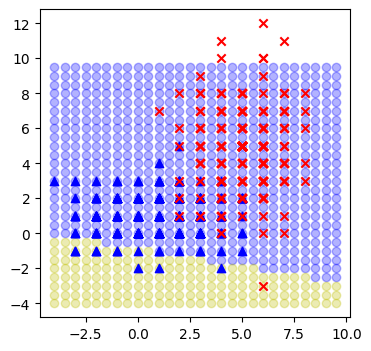

loss : 1481.0524096307304


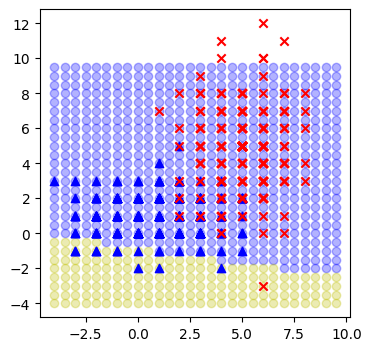

Epoch 6
-------------------------------
loss : 1480.7902728460806


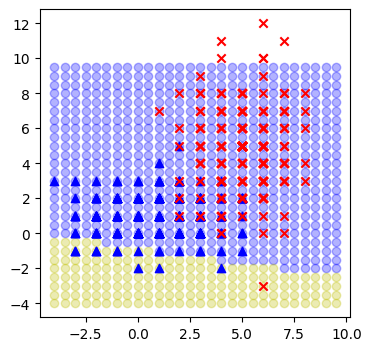

loss : 1417.6038948383166


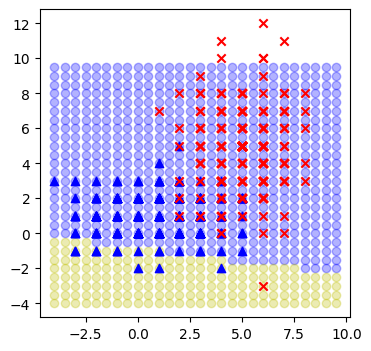

Epoch 7
-------------------------------
loss : 1417.343207390099


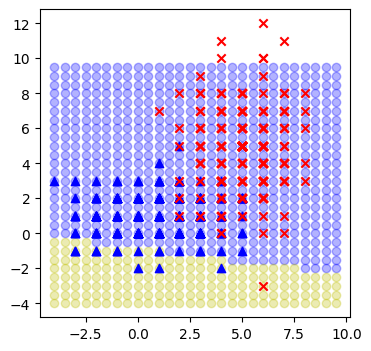

loss : 1354.5126022412162


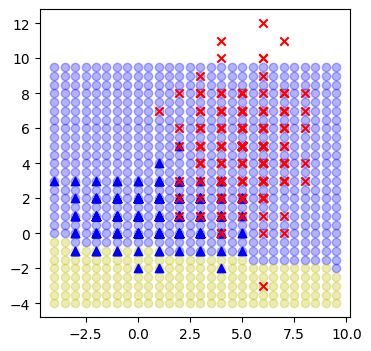

Epoch 8
-------------------------------
loss : 1354.2535894485222


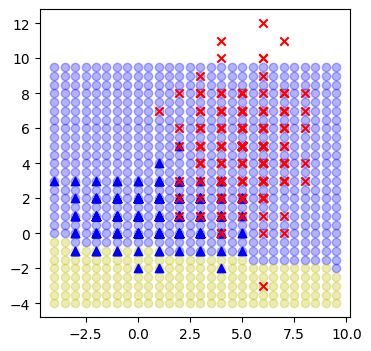

loss : 1291.849206480177


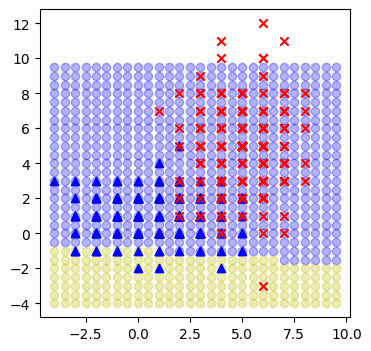

Epoch 9
-------------------------------
loss : 1291.592137666953


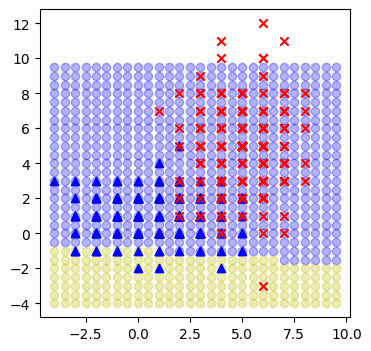

loss : 1229.6982773284278


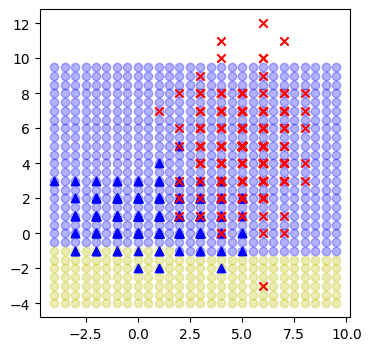

Epoch 10
-------------------------------
loss : 1229.4434746985708


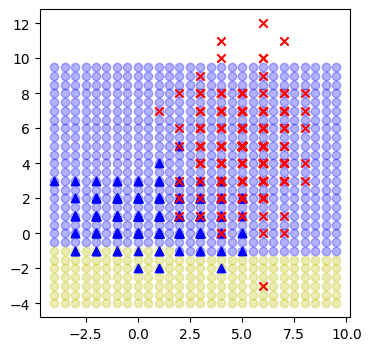

loss : 1168.1606080821164


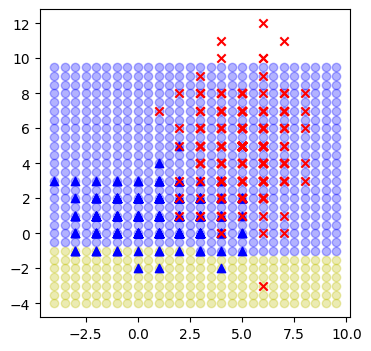

Epoch 11
-------------------------------
loss : 1167.9084569396923


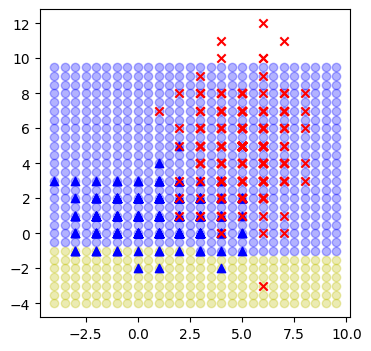

loss : 1107.355675534013


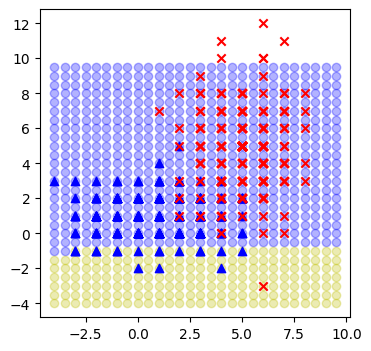

Epoch 12
-------------------------------
loss : 1107.1066357061677


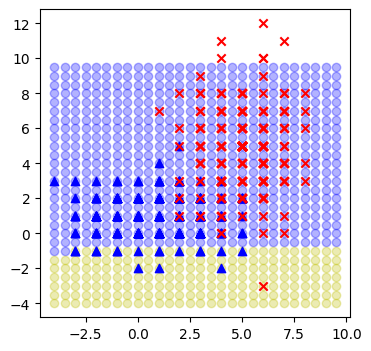

loss : 1047.4240803346815


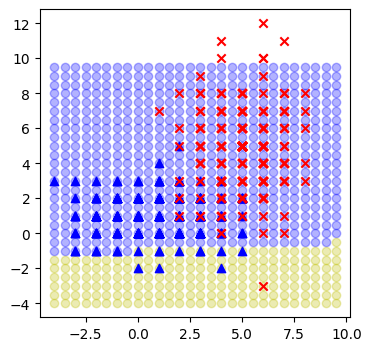

Epoch 13
-------------------------------
loss : 1047.1786983823542


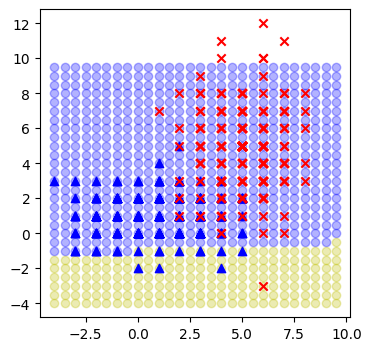

loss : 988.5297190007361


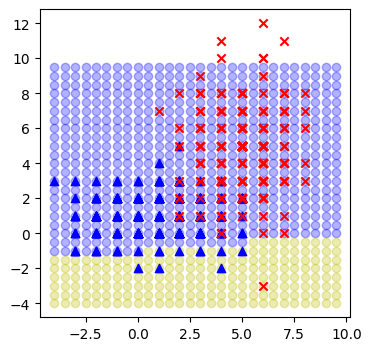

Epoch 14
-------------------------------
loss : 988.2886403843627


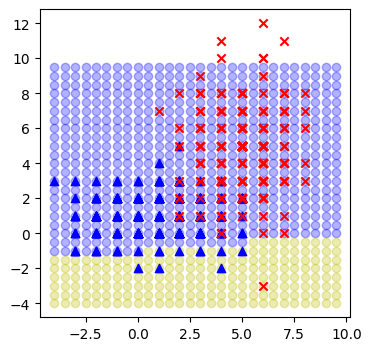

loss : 930.8613154441467


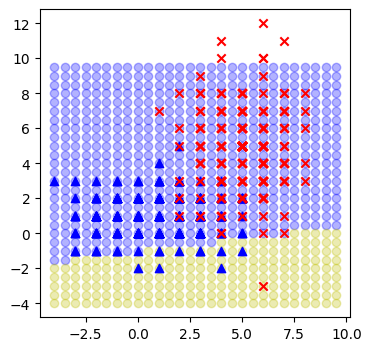

Epoch 15
-------------------------------
loss : 930.6252952220145


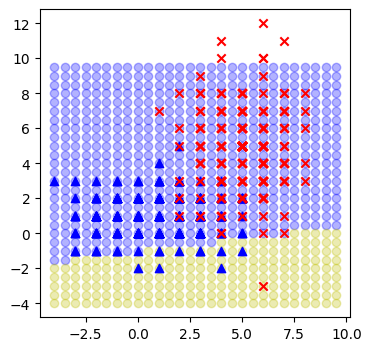

loss : 874.632802539765


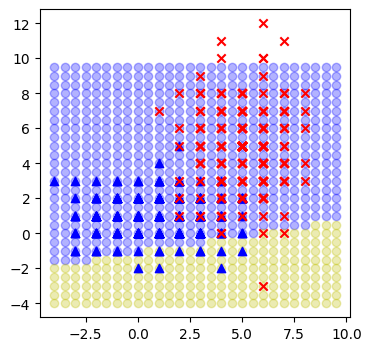

Epoch 16
-------------------------------
loss : 874.4027124263031


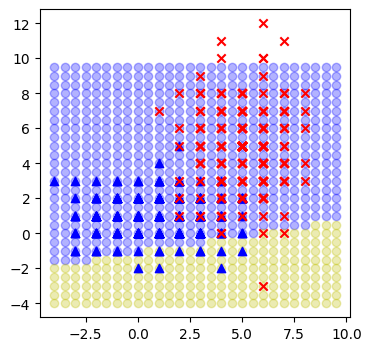

loss : 820.0819219259976


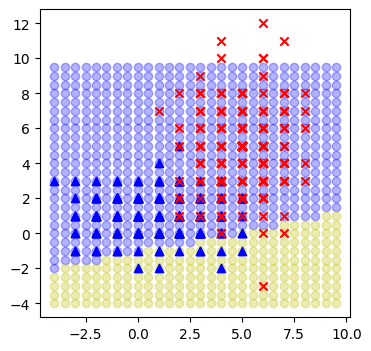

Epoch 17
-------------------------------
loss : 819.858750708606


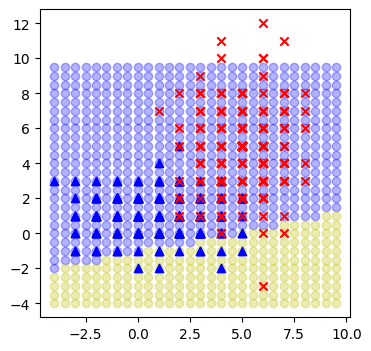

loss : 767.4663531687183


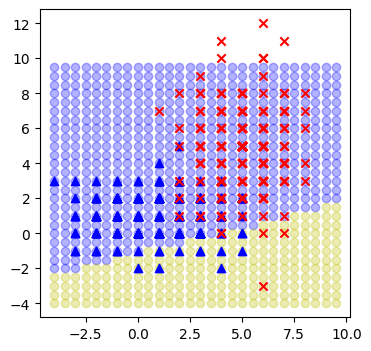

Epoch 18
-------------------------------
loss : 767.2511967729192


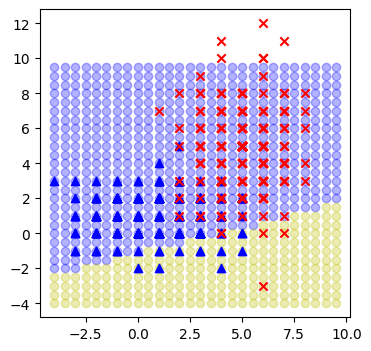

loss : 717.0567588385043


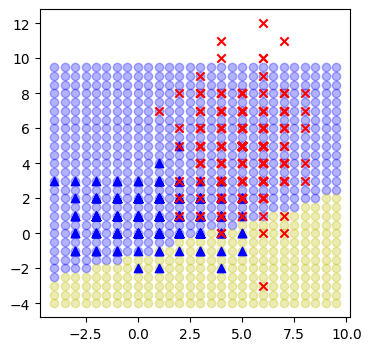

Epoch 19
-------------------------------
loss : 716.8507960826537


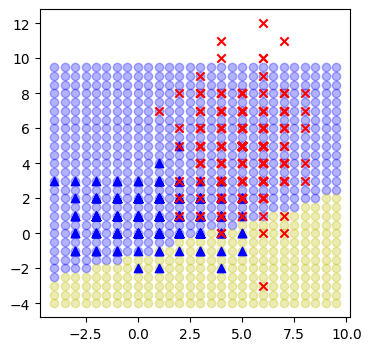

loss : 669.1264058770079


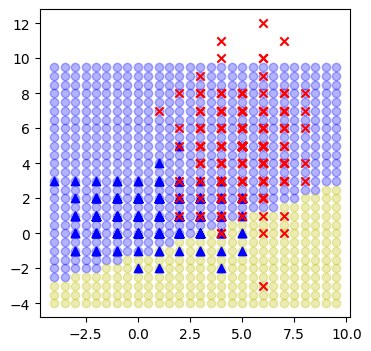

Epoch 20
-------------------------------
loss : 668.9308566265586


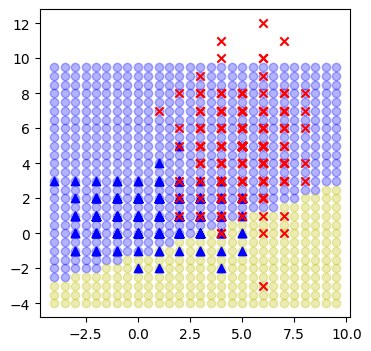

loss : 623.9375281827371


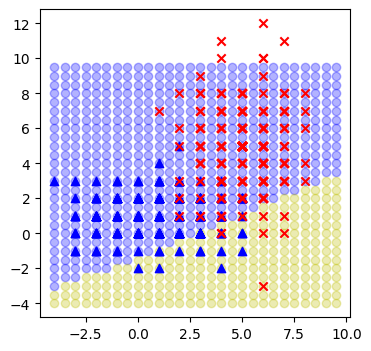

Epoch 21
-------------------------------
loss : 623.7535926523053


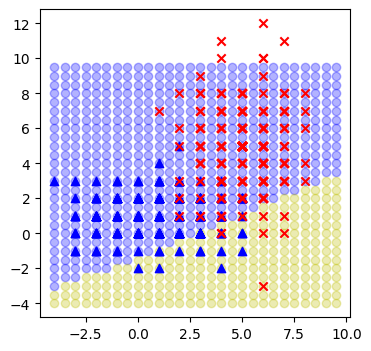

loss : 581.7252939280626


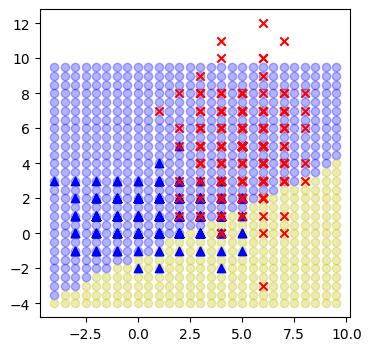

Epoch 22
-------------------------------
loss : 581.554075491295


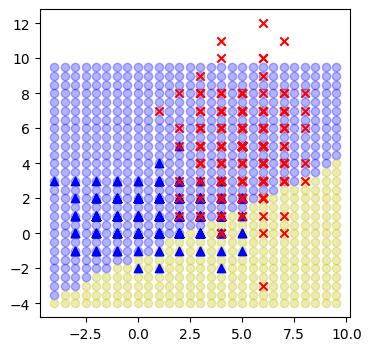

loss : 542.6810072939977


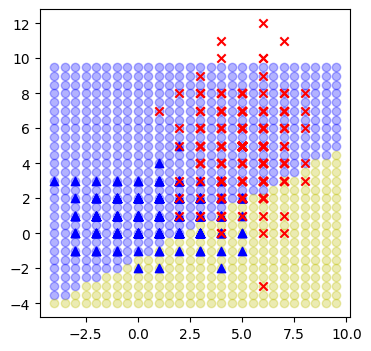

Epoch 23
-------------------------------
loss : 542.523425971929


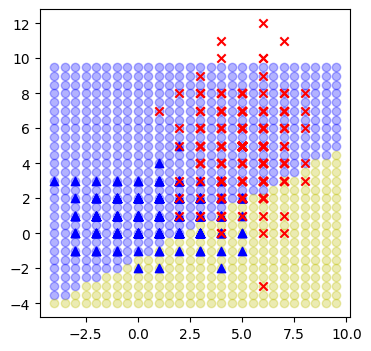

loss : 506.9367994065228


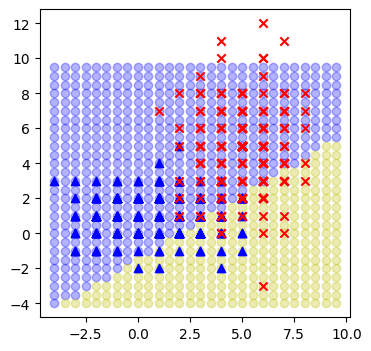

Epoch 24
-------------------------------
loss : 506.7935079988044


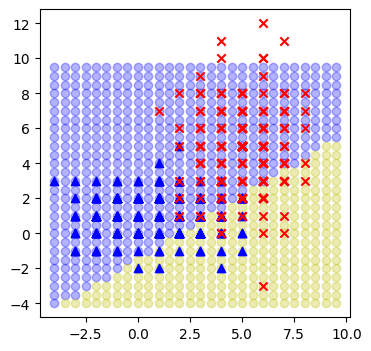

loss : 474.554297417356


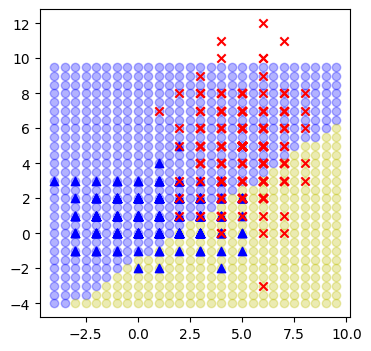

Epoch 25
-------------------------------
loss : 474.42561506207477


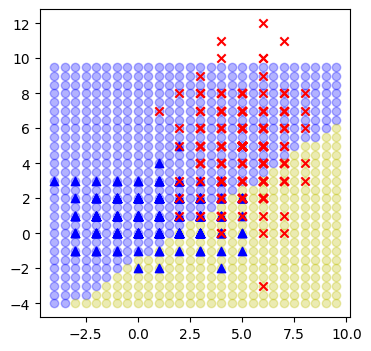

loss : 445.5193943295353


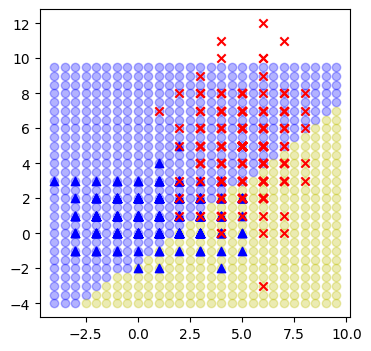

Epoch 26
-------------------------------
loss : 445.4052711823183


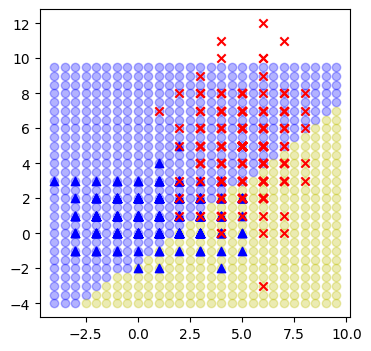

loss : 419.74422785275493


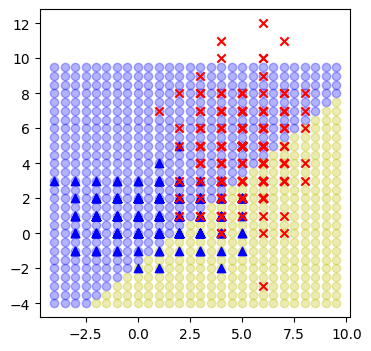

Epoch 27
-------------------------------
loss : 419.64424888986434


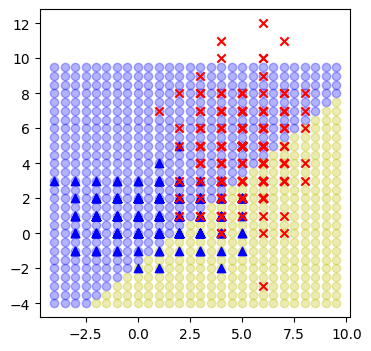

loss : 397.0760369207477


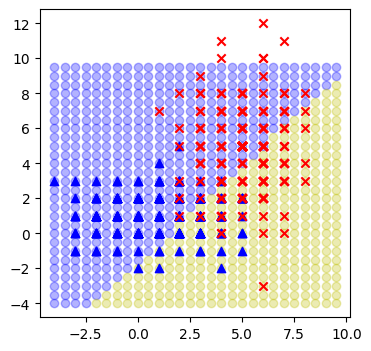

Epoch 28
-------------------------------
loss : 396.98946410989913


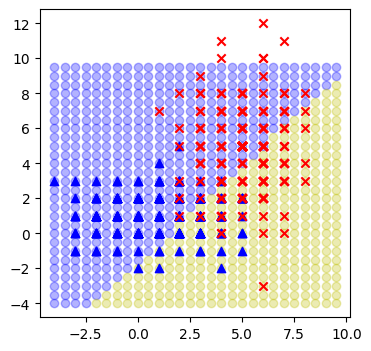

loss : 377.3111694506004


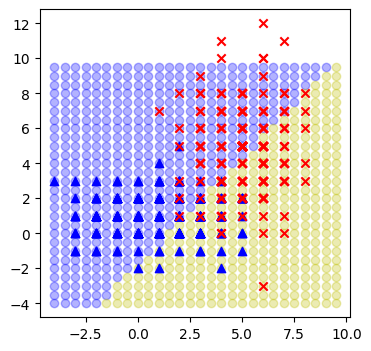

Epoch 29
-------------------------------
loss : 377.2370129734745


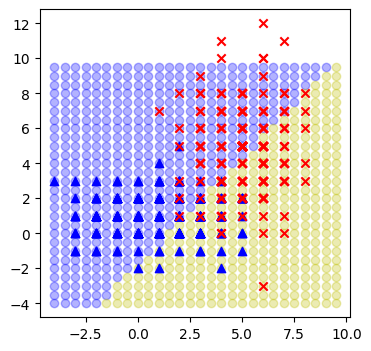

loss : 360.21166549611473


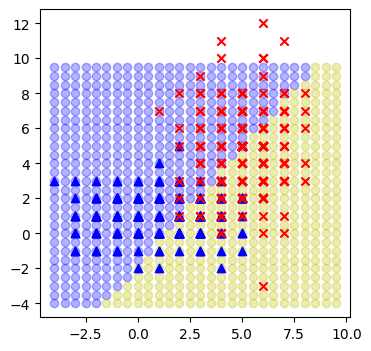

Epoch 30
-------------------------------
loss : 360.14876958429693


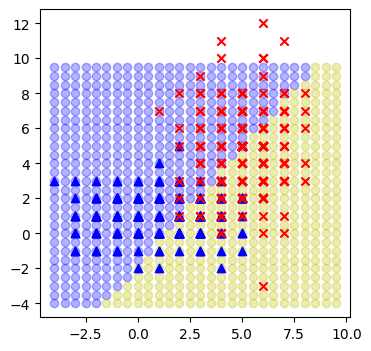

loss : 345.52178349324856


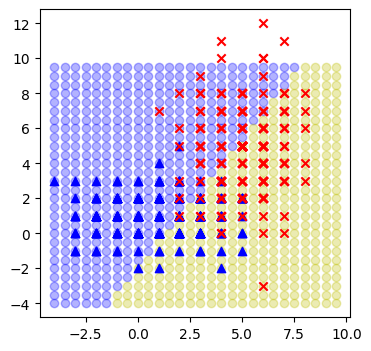

In [6]:
demo_neuron = Neuron(2)
output = OutputLayer(2)

draw_neuron_boundary(demo_neuron, train_features, train_labels, markers, colors)

epochs = 30
m = train_labels.shape[1]
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    
    for train_iter_id in range(m):
        h = demo_neuron.forward(train_features)
        predicts, loss = output.forward(h, train_labels)

        dL_by_dH = output.backward()
        dL_by_dW = demo_neuron.backward(dL_by_dH)
        demo_neuron.update_parameters(dL_by_dW, train_iter_id)

        if train_iter_id % (m-1) == 0:
            print('loss :', loss)
            draw_neuron_boundary(demo_neuron, train_features, train_labels, markers, colors)

In [7]:
def draw_neuron_boundary_2(weights, bias, features, labels, markers, colors):
    # Define the grid of points
    grid_step = 0.5
    xx, yy = np.meshgrid(np.arange(-4, 10, grid_step), np.arange(-4, 10, grid_step))
    grid_points = np.c_[xx.ravel(), yy.ravel()].T

    # Predict
    #predict = neuron.predict(grid_points)
    X = grid_points
    m = X.shape[1]
    b = np.ones((1, m))
    x = np.concatenate((X, b), axis=0)

    # weights bias tensor
    nn_weights = weights.numpy()
    nn_bias = bias.numpy().reshape((1, 1))
    W = np.concatenate((nn_weights.T, nn_bias), axis=0)
    z = W.T.dot(x)
    predict = sigmod(z)

    # Create the scatter plot with decision boundary
    positive_index = np.where(predict[0,:] > 0.5)
    negative_index = np.where(predict[0,:] <= 0.5)

    plt.figure(figsize=(4, 4))
    plt.scatter(grid_points[0, positive_index], grid_points[1, positive_index], c='b', alpha=0.3)
    plt.scatter(grid_points[0, negative_index], grid_points[1, negative_index], c='y', alpha=0.3)

    for i in range(2):
        x = features[0, np.where(labels[i, :] == 1)]
        y = features[1, np.where(labels[i, :] == 1)]
        plt.scatter(x, y, marker=markers[i], c=colors[i])

    plt.show()

TorchNN(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=2, out_features=1, bias=True)
  (A): Sigmoid()
  (output): Linear(in_features=1, out_features=2, bias=True)
)
Epoch 1
-------------------------------
loss: 1.234459  [    1/  540]


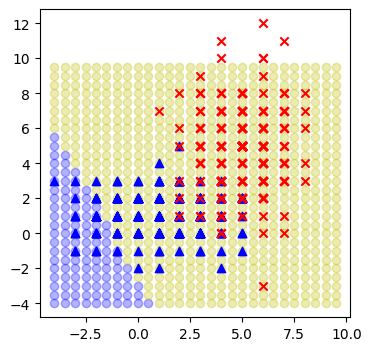

loss: 0.460621  [  101/  540]


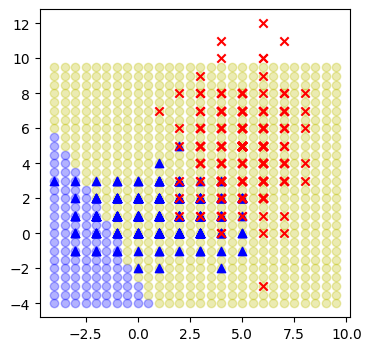

loss: 0.508039  [  201/  540]


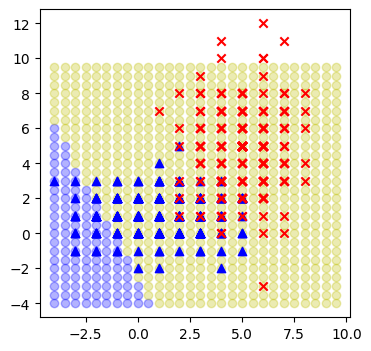

loss: 0.582926  [  301/  540]


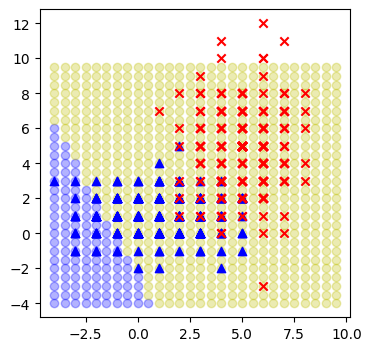

loss: 0.749295  [  401/  540]


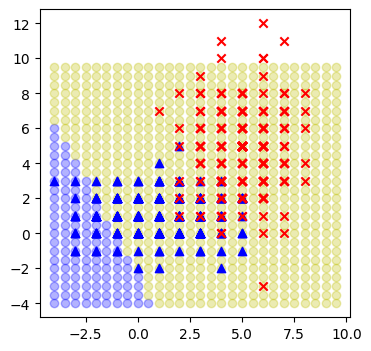

loss: 0.555520  [  501/  540]


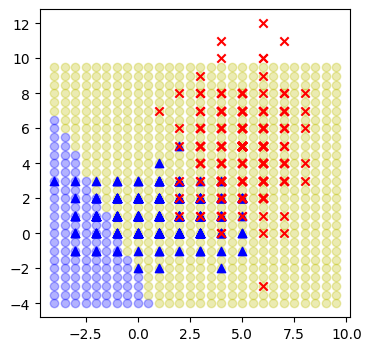

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.655310 

Epoch 2
-------------------------------
loss: 0.729192  [    1/  540]


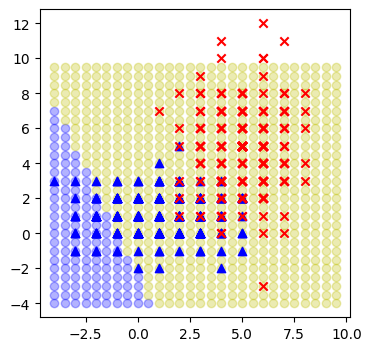

loss: 0.552007  [  101/  540]


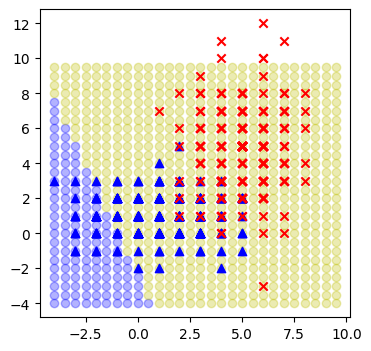

loss: 0.556536  [  201/  540]


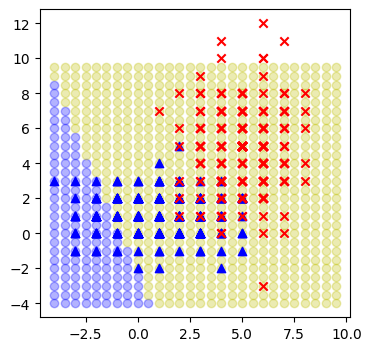

loss: 0.599442  [  301/  540]


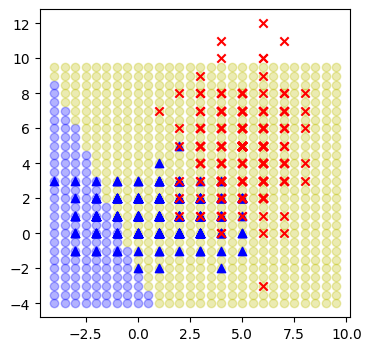

loss: 0.670790  [  401/  540]


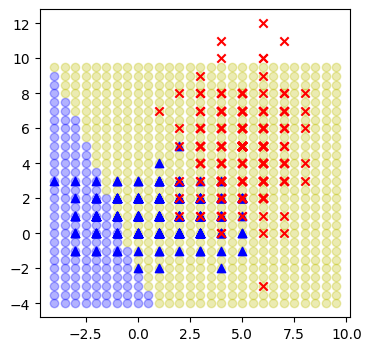

loss: 0.540421  [  501/  540]


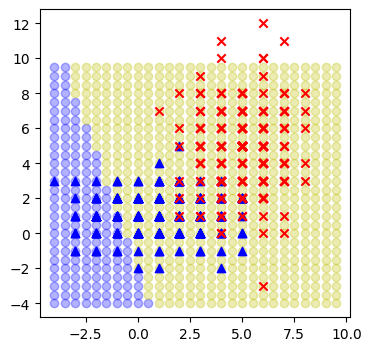

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.618595 

Epoch 3
-------------------------------
loss: 0.663083  [    1/  540]


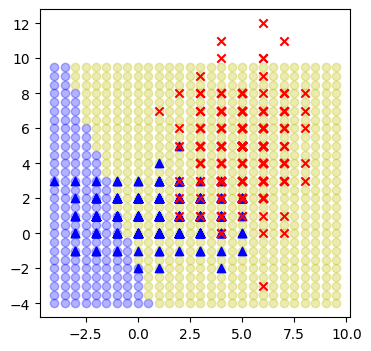

loss: 0.433047  [  101/  540]


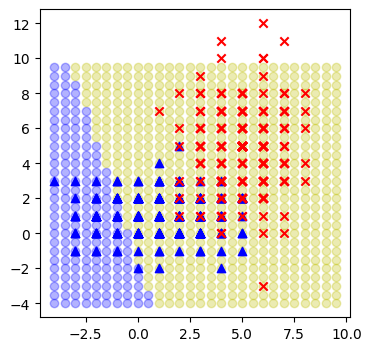

loss: 0.461899  [  201/  540]


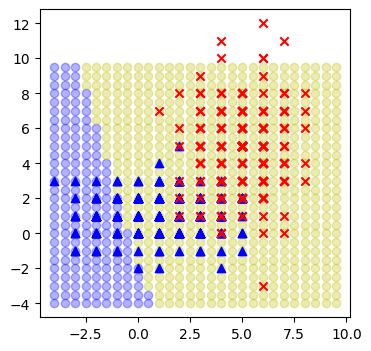

loss: 0.521376  [  301/  540]


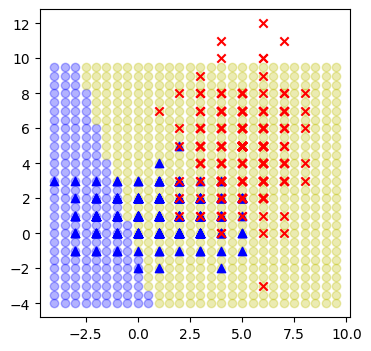

loss: 0.642994  [  401/  540]


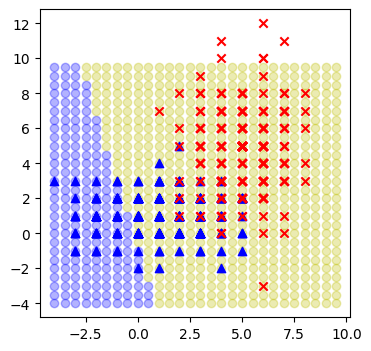

loss: 0.487490  [  501/  540]


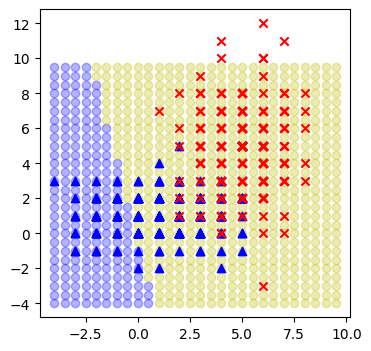

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.576096 

Epoch 4
-------------------------------
loss: 0.611300  [    1/  540]


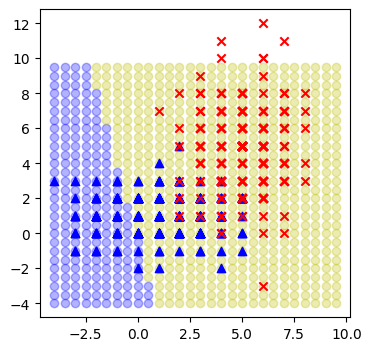

loss: 0.311684  [  101/  540]


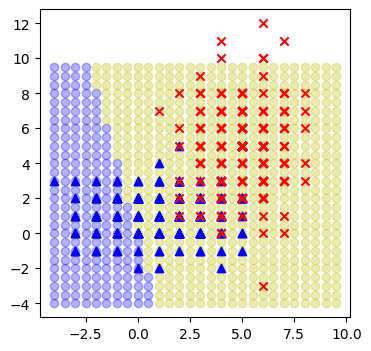

loss: 0.356939  [  201/  540]


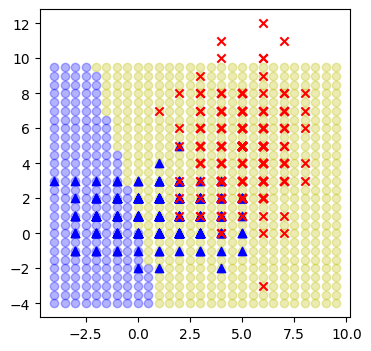

loss: 0.426515  [  301/  540]


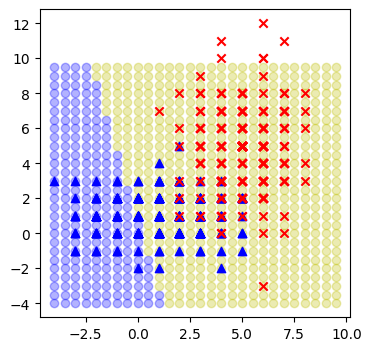

loss: 0.614010  [  401/  540]


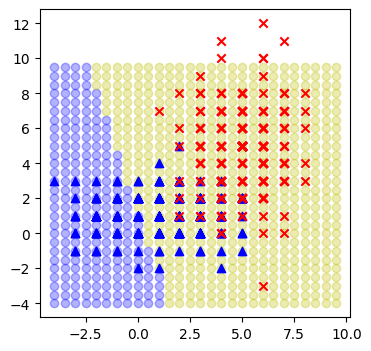

loss: 0.410830  [  501/  540]


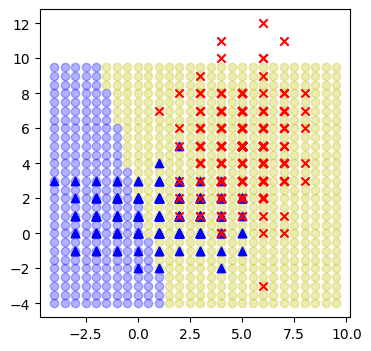

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.526305 

Epoch 5
-------------------------------
loss: 0.552884  [    1/  540]


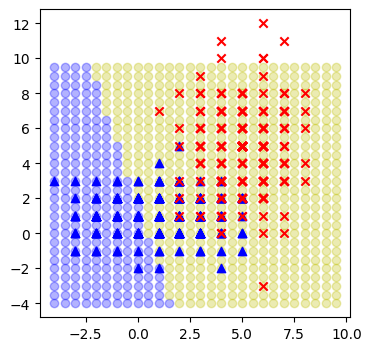

loss: 0.222599  [  101/  540]


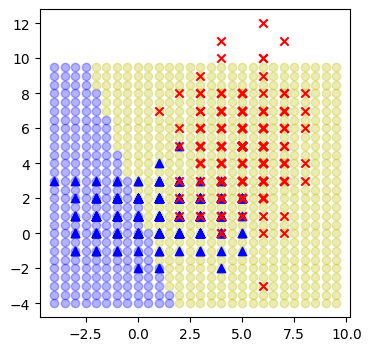

loss: 0.276164  [  201/  540]


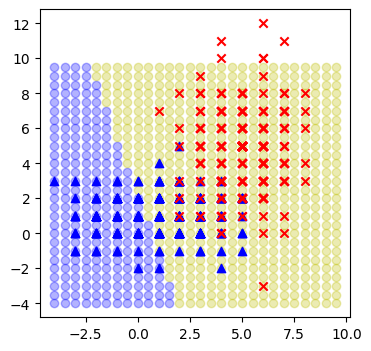

loss: 0.334858  [  301/  540]


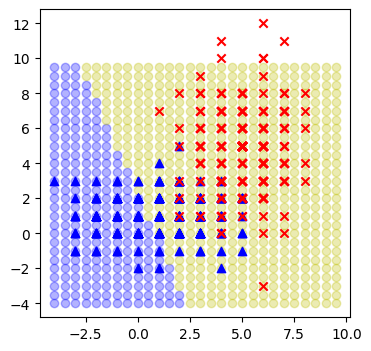

loss: 0.569846  [  401/  540]


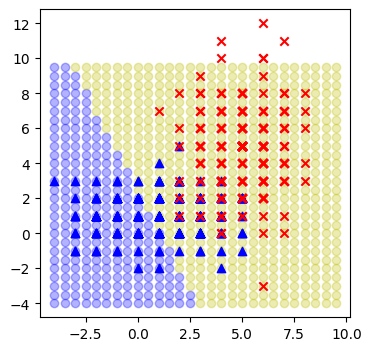

loss: 0.314882  [  501/  540]


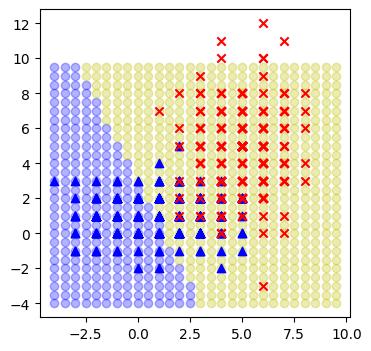

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.467488 

Epoch 6
-------------------------------
loss: 0.488850  [    1/  540]


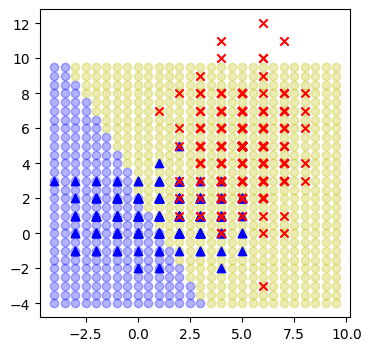

loss: 0.165244  [  101/  540]


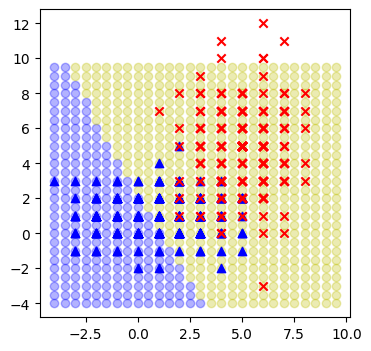

loss: 0.224496  [  201/  540]


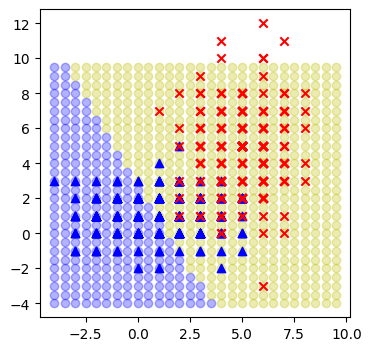

loss: 0.259144  [  301/  540]


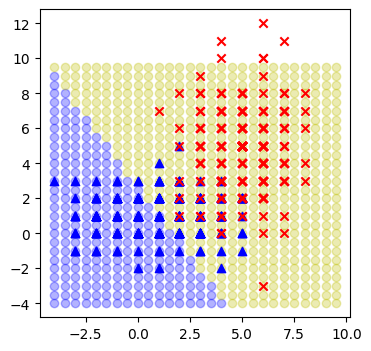

loss: 0.496893  [  401/  540]


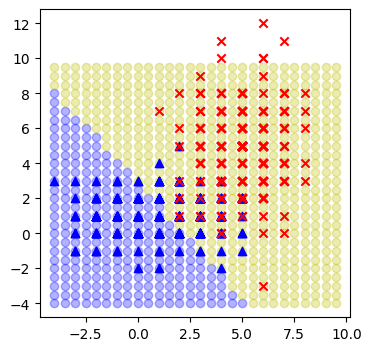

loss: 0.227049  [  501/  540]


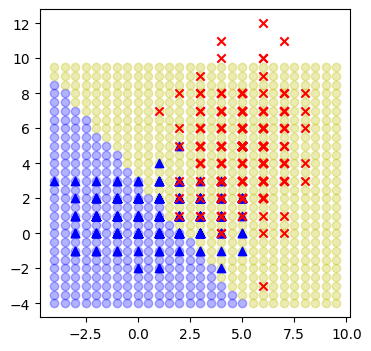

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.404003 

Epoch 7
-------------------------------
loss: 0.418820  [    1/  540]


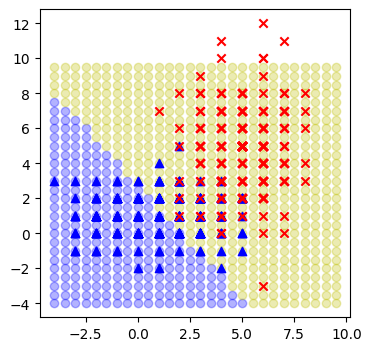

loss: 0.124693  [  101/  540]


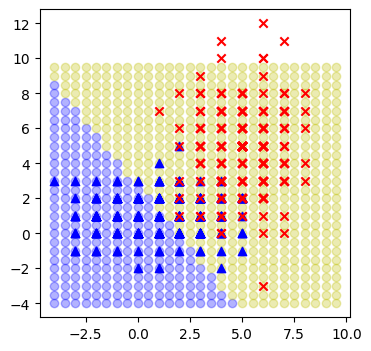

loss: 0.183908  [  201/  540]


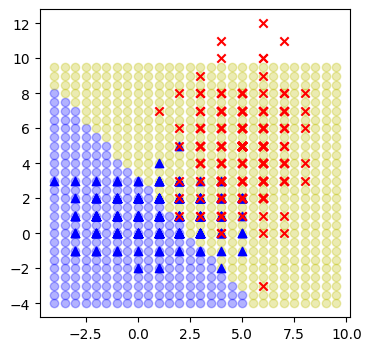

loss: 0.198319  [  301/  540]


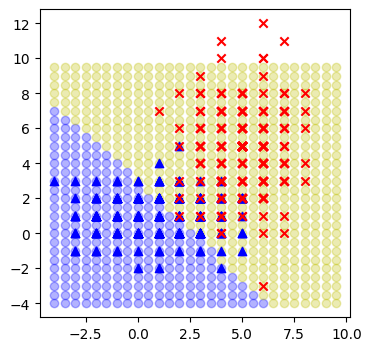

loss: 0.413876  [  401/  540]


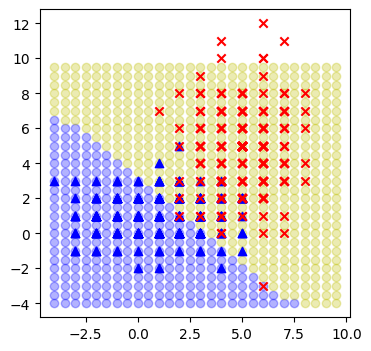

loss: 0.164471  [  501/  540]


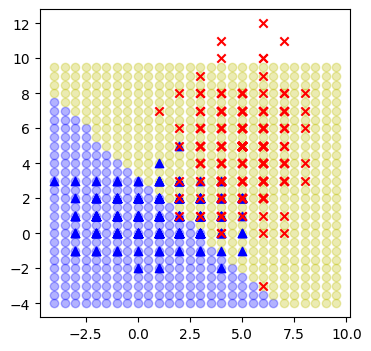

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.347258 

Epoch 8
-------------------------------
loss: 0.350240  [    1/  540]


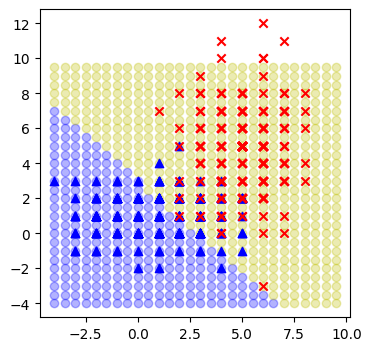

loss: 0.093020  [  101/  540]


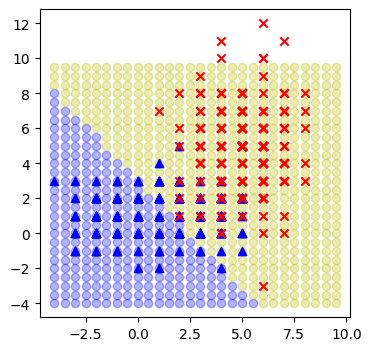

loss: 0.143319  [  201/  540]


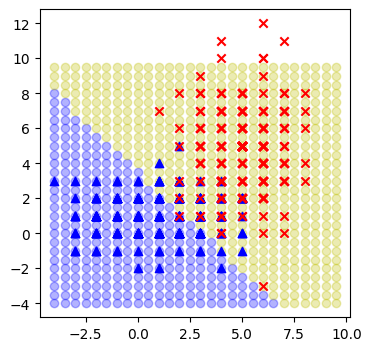

loss: 0.149543  [  301/  540]


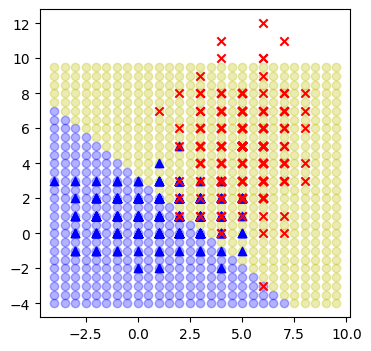

loss: 0.346983  [  401/  540]


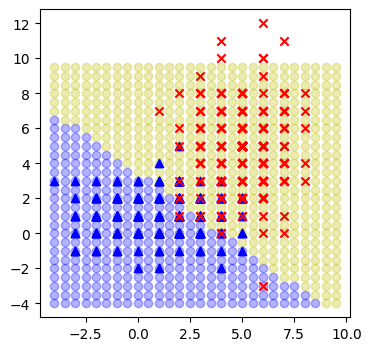

loss: 0.122879  [  501/  540]


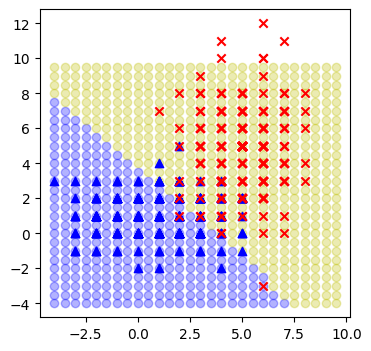

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.302112 

Epoch 9
-------------------------------
loss: 0.292200  [    1/  540]


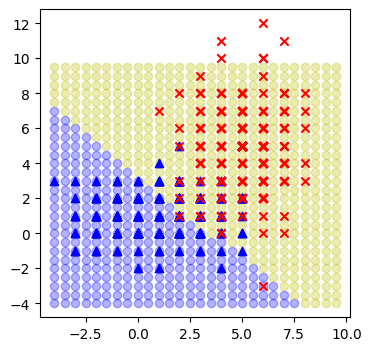

loss: 0.070434  [  101/  540]


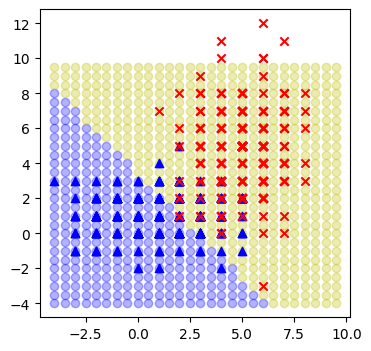

loss: 0.109054  [  201/  540]


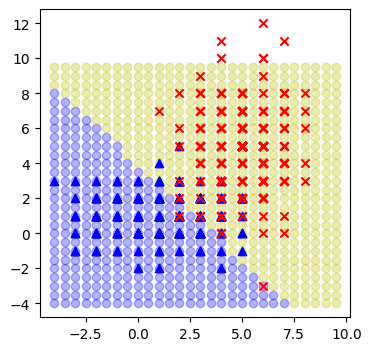

loss: 0.113514  [  301/  540]


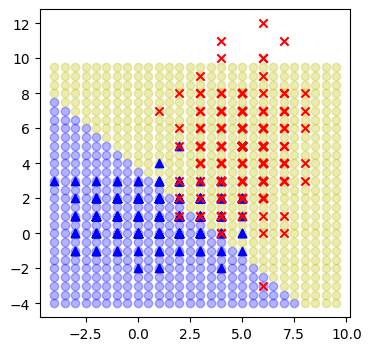

loss: 0.297125  [  401/  540]


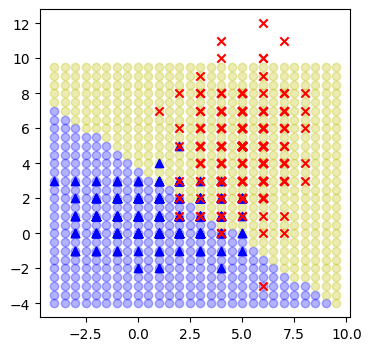

loss: 0.095050  [  501/  540]


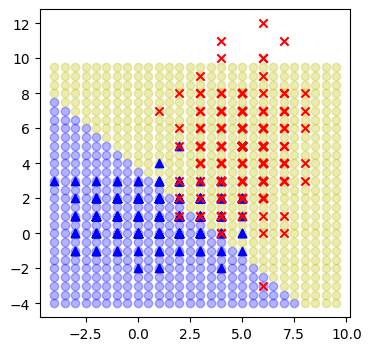

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.267435 

Epoch 10
-------------------------------
loss: 0.246177  [    1/  540]


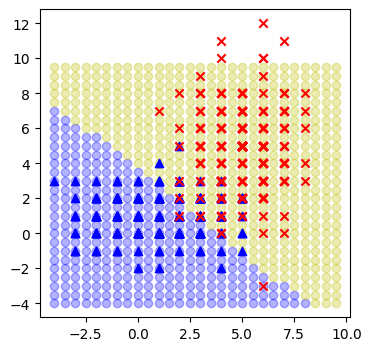

loss: 0.055215  [  101/  540]


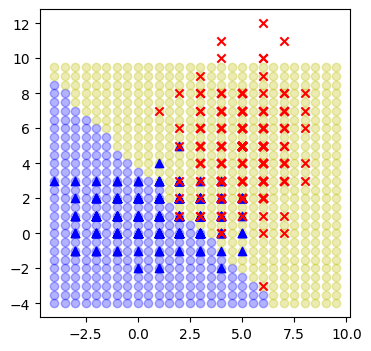

loss: 0.083866  [  201/  540]


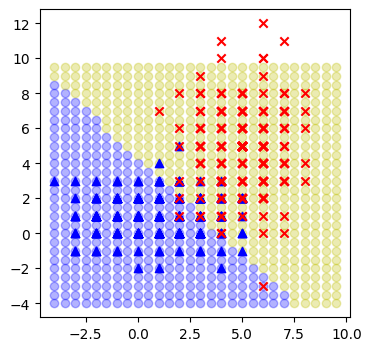

loss: 0.088146  [  301/  540]


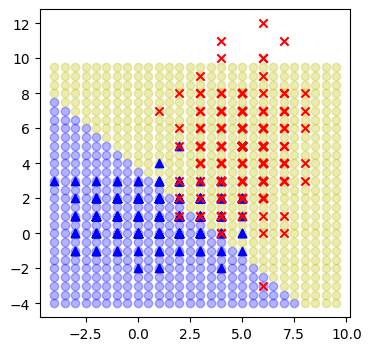

loss: 0.259620  [  401/  540]


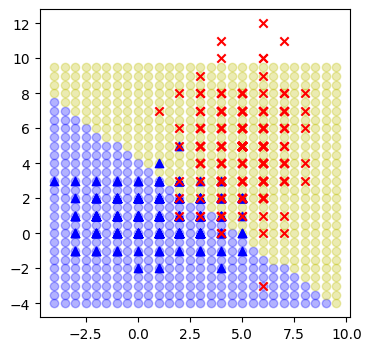

loss: 0.075968  [  501/  540]


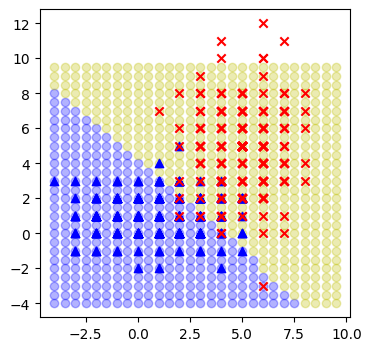

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.240935 

Epoch 11
-------------------------------
loss: 0.210231  [    1/  540]


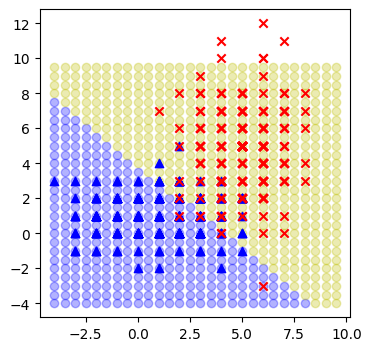

loss: 0.044872  [  101/  540]


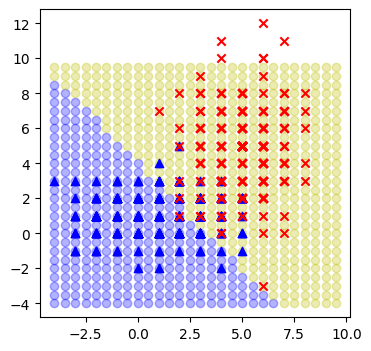

loss: 0.066127  [  201/  540]


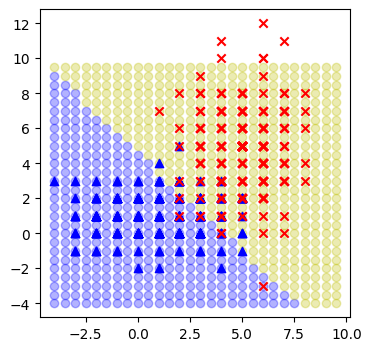

loss: 0.070349  [  301/  540]


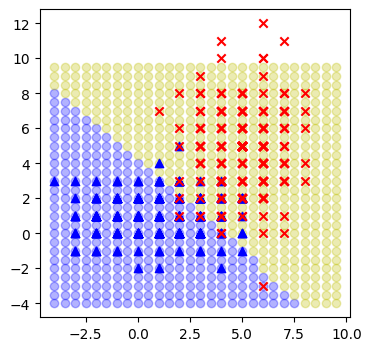

loss: 0.230852  [  401/  540]


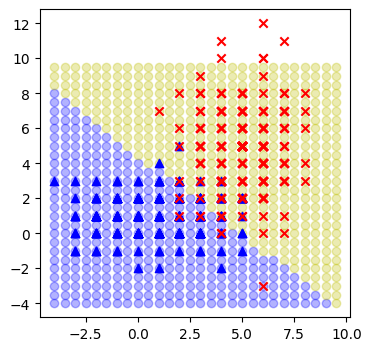

loss: 0.062485  [  501/  540]


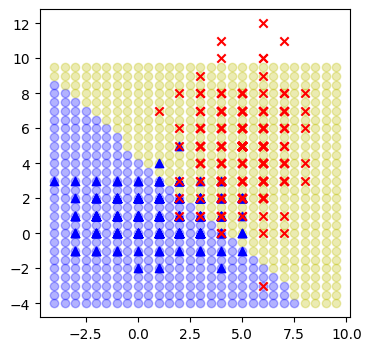

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.220552 

Epoch 12
-------------------------------
loss: 0.182041  [    1/  540]


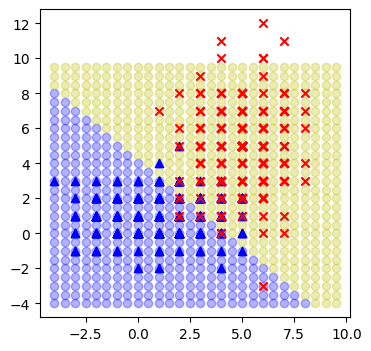

loss: 0.037612  [  101/  540]


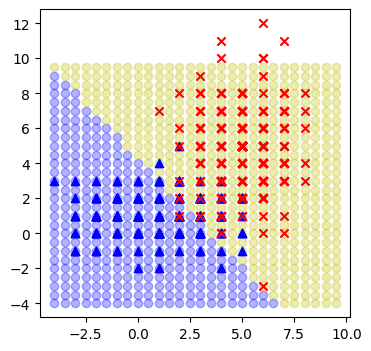

loss: 0.053609  [  201/  540]


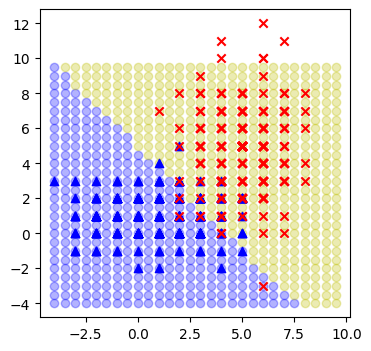

loss: 0.057657  [  301/  540]


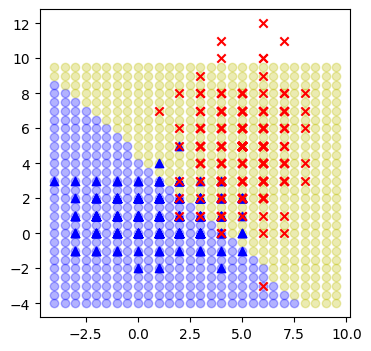

loss: 0.208320  [  401/  540]


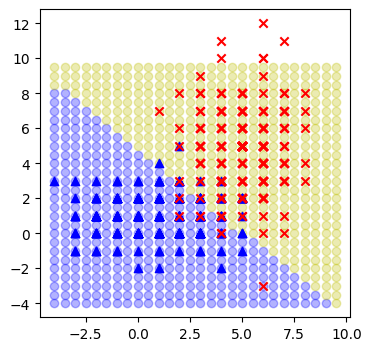

loss: 0.052665  [  501/  540]


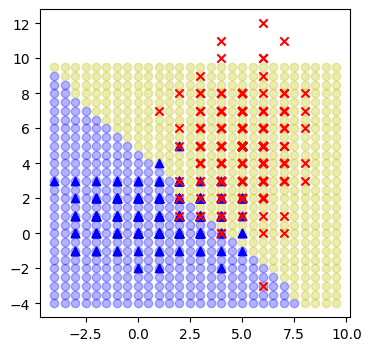

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.204691 

Epoch 13
-------------------------------
loss: 0.159676  [    1/  540]


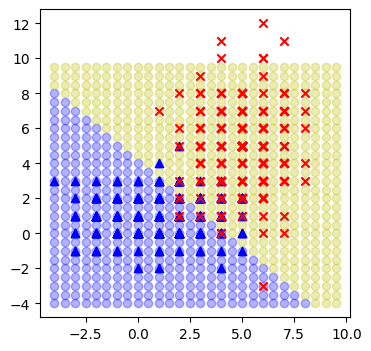

loss: 0.032333  [  101/  540]


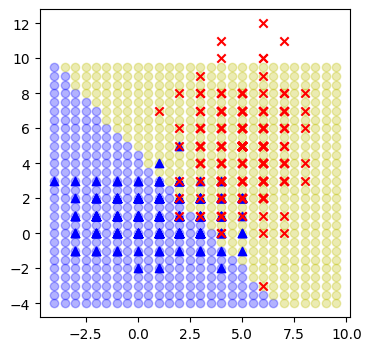

loss: 0.044606  [  201/  540]


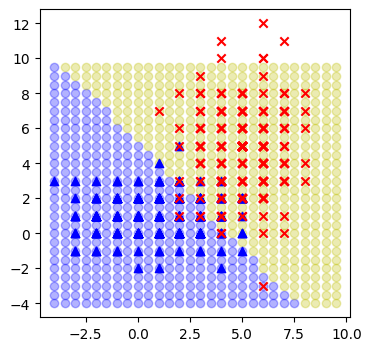

loss: 0.048393  [  301/  540]


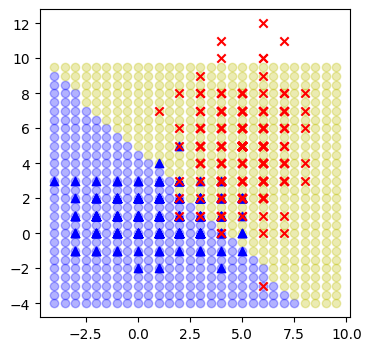

loss: 0.190305  [  401/  540]


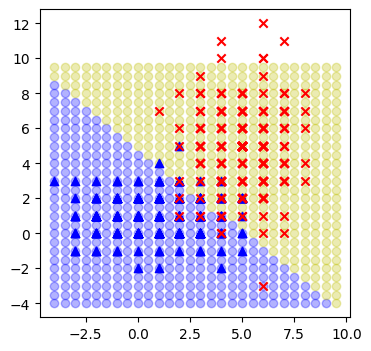

loss: 0.045307  [  501/  540]


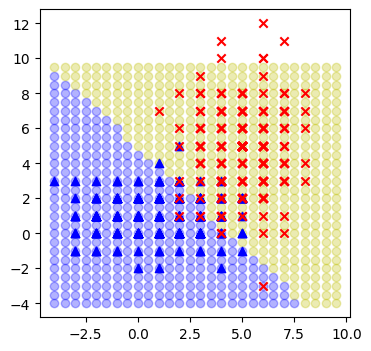

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.192185 

Epoch 14
-------------------------------
loss: 0.141685  [    1/  540]


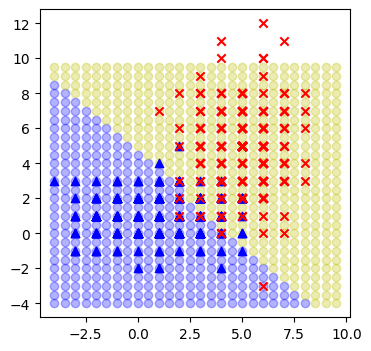

loss: 0.028368  [  101/  540]


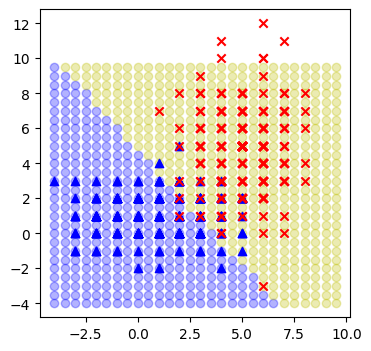

loss: 0.037977  [  201/  540]


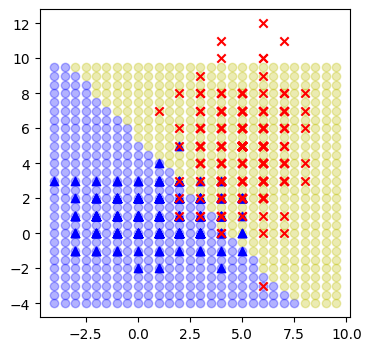

loss: 0.041466  [  301/  540]


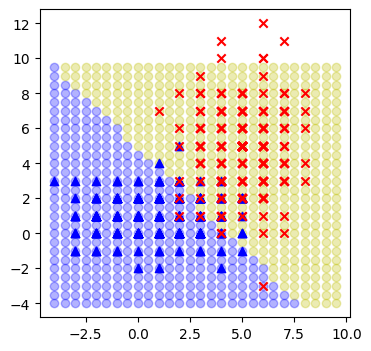

loss: 0.175622  [  401/  540]


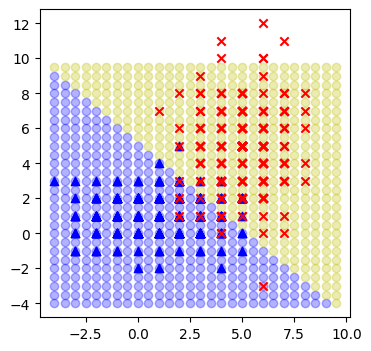

loss: 0.039655  [  501/  540]


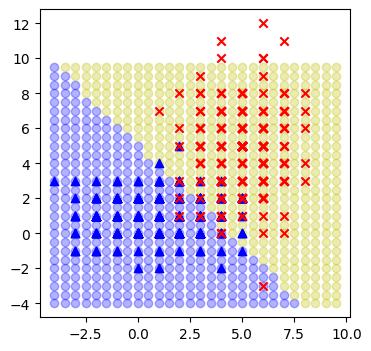

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.182189 

Epoch 15
-------------------------------
loss: 0.127007  [    1/  540]


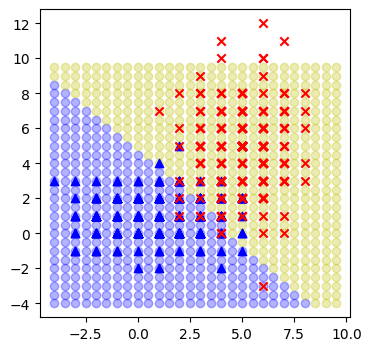

loss: 0.025306  [  101/  540]


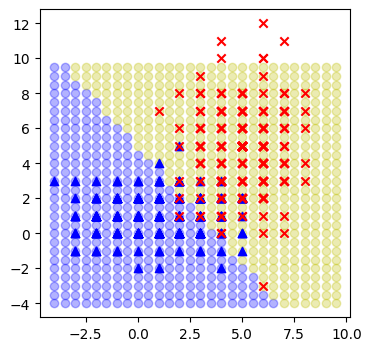

loss: 0.032974  [  201/  540]


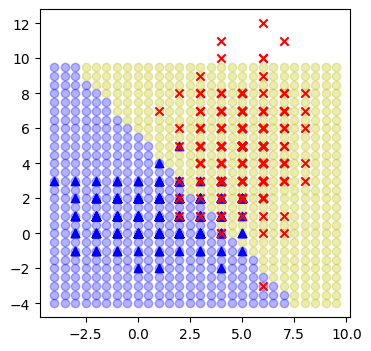

loss: 0.036166  [  301/  540]


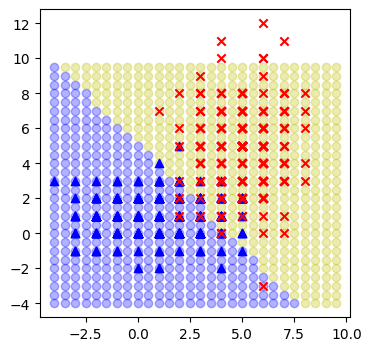

loss: 0.163444  [  401/  540]


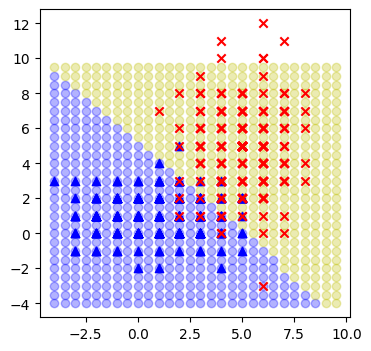

loss: 0.035216  [  501/  540]


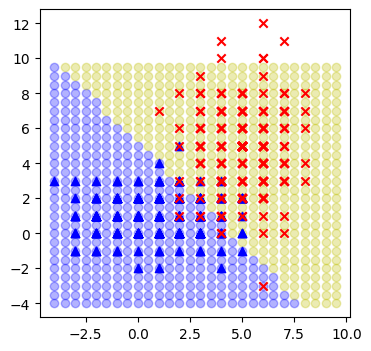

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.174098 

Epoch 16
-------------------------------
loss: 0.114873  [    1/  540]


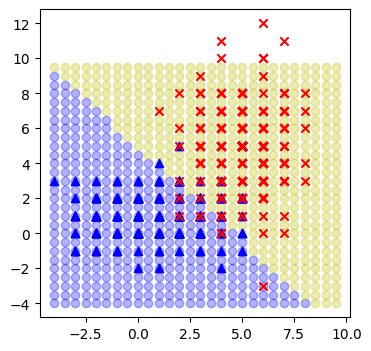

loss: 0.022883  [  101/  540]


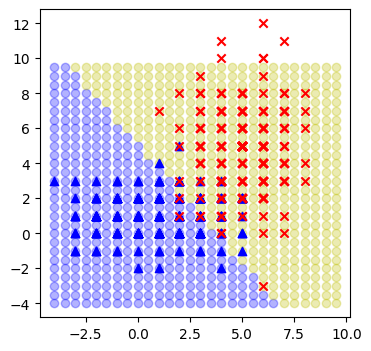

loss: 0.029113  [  201/  540]


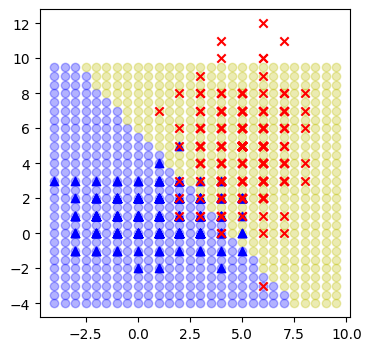

loss: 0.032026  [  301/  540]


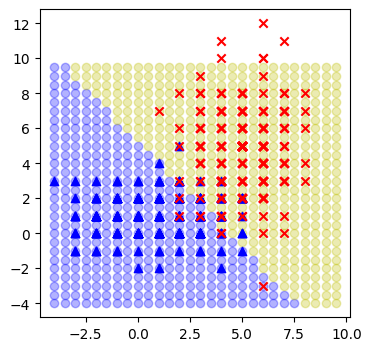

loss: 0.153190  [  401/  540]


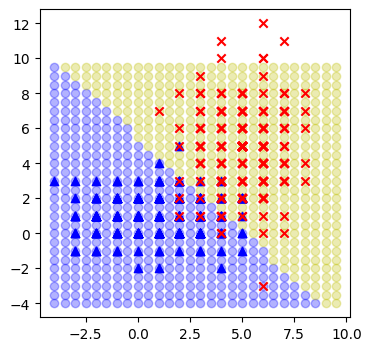

loss: 0.031664  [  501/  540]


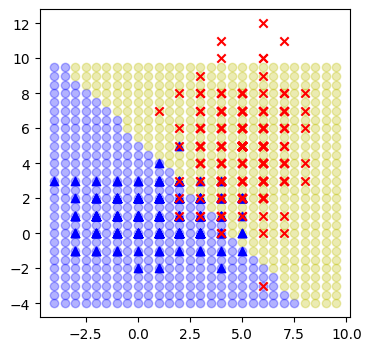

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.167470 

Epoch 17
-------------------------------
loss: 0.104720  [    1/  540]


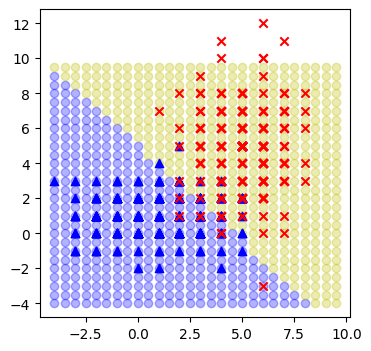

loss: 0.020928  [  101/  540]


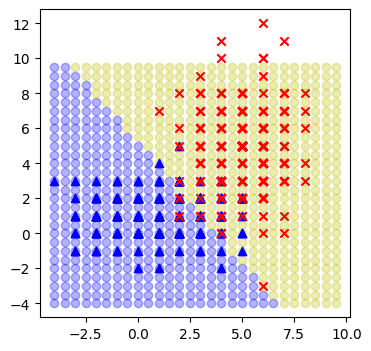

loss: 0.026071  [  201/  540]


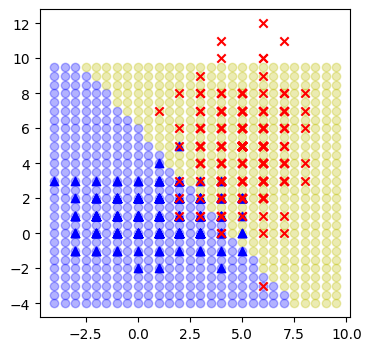

loss: 0.028730  [  301/  540]


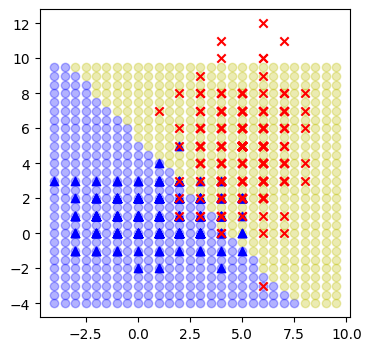

loss: 0.144441  [  401/  540]


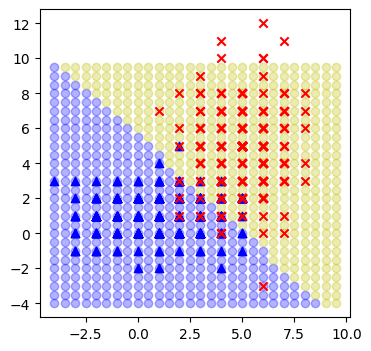

loss: 0.028774  [  501/  540]


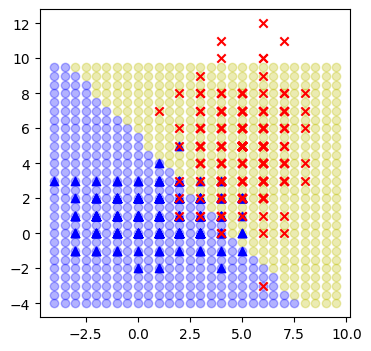

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.161983 

Epoch 18
-------------------------------
loss: 0.096131  [    1/  540]


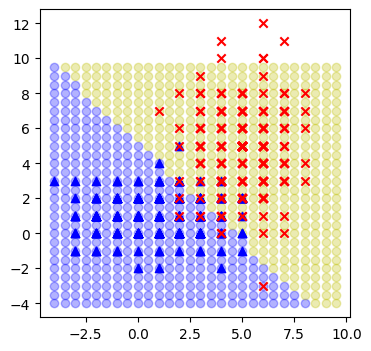

loss: 0.019324  [  101/  540]


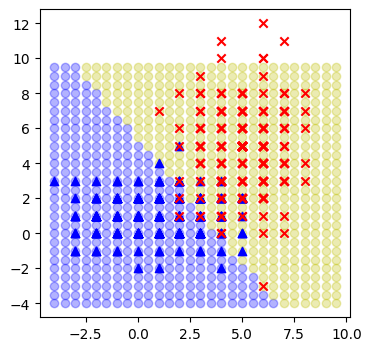

loss: 0.023629  [  201/  540]


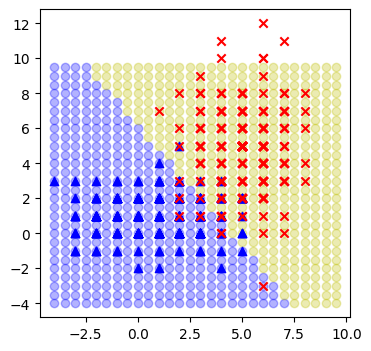

loss: 0.026063  [  301/  540]


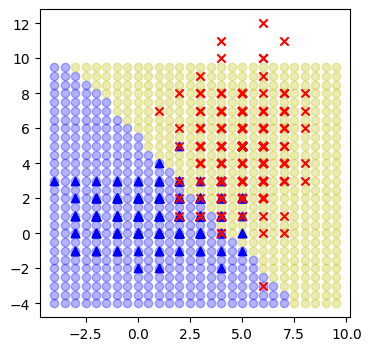

loss: 0.136890  [  401/  540]


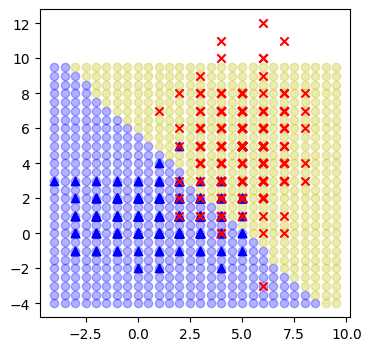

loss: 0.026390  [  501/  540]


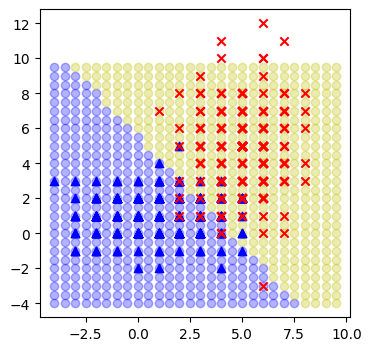

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.157397 

Epoch 19
-------------------------------
loss: 0.088794  [    1/  540]


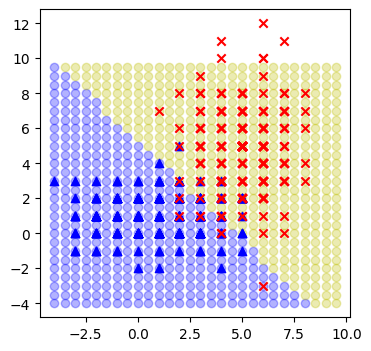

loss: 0.017987  [  101/  540]


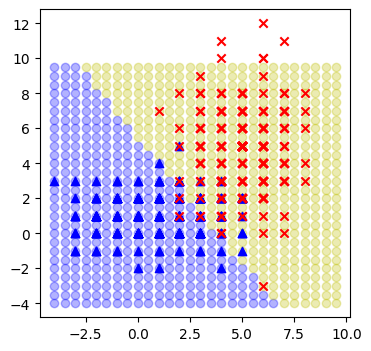

loss: 0.021638  [  201/  540]


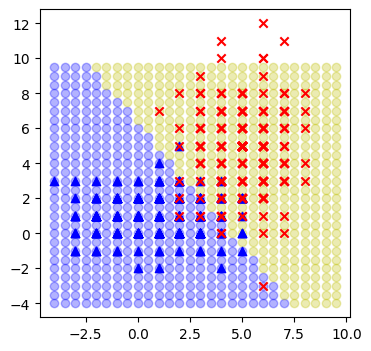

loss: 0.023872  [  301/  540]


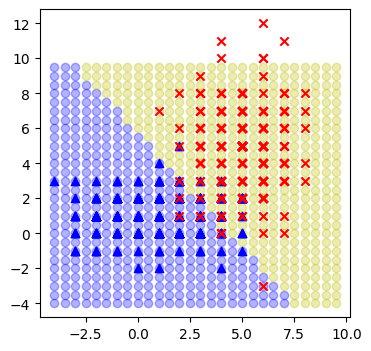

loss: 0.130306  [  401/  540]


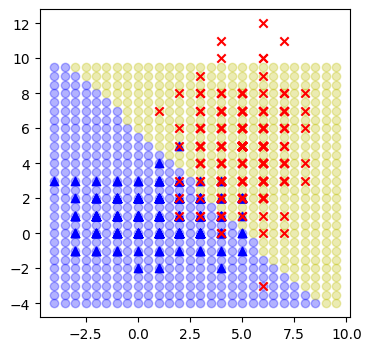

loss: 0.024397  [  501/  540]


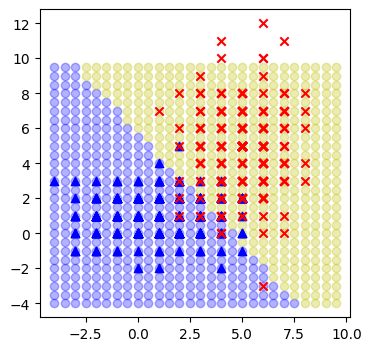

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.153529 

Epoch 20
-------------------------------
loss: 0.082469  [    1/  540]


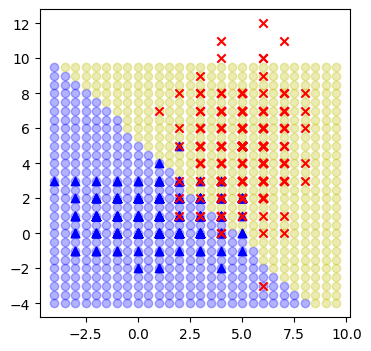

loss: 0.016861  [  101/  540]


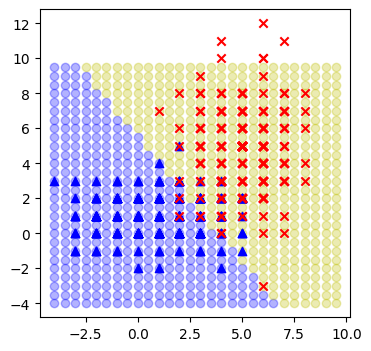

loss: 0.019992  [  201/  540]


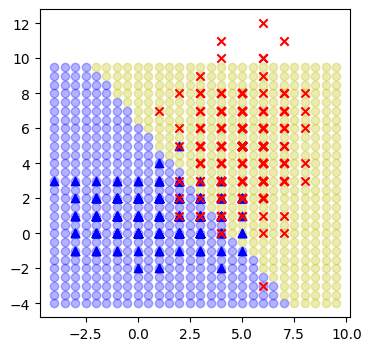

loss: 0.022051  [  301/  540]


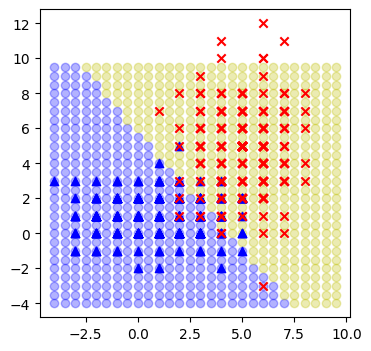

loss: 0.124516  [  401/  540]


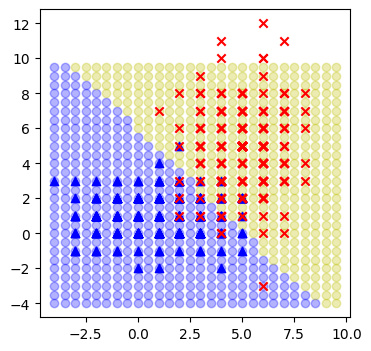

loss: 0.022714  [  501/  540]


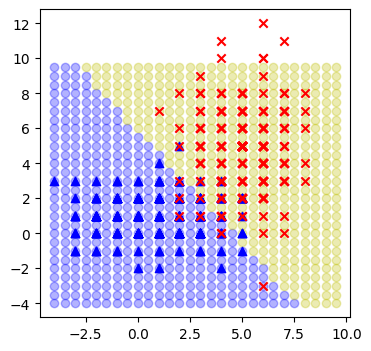

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.150243 

Done!


In [9]:
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset

train_X = torch.Tensor(train_features.T) # transform to torch tensor
train_y = torch.Tensor(train_labels.T)
#print('train_X ', train_X.shape)
#print('train_y ', train_y.shape)
train_dataset = TensorDataset(train_X, train_y)
train_dataloader = DataLoader(train_dataset)
#print('train_dl ', type(train_dataloader.dataset))
#print('train_dl ', len(train_dataloader.dataset))

test_X = torch.Tensor(test_features.T) # transform to torch tensor
test_y = torch.Tensor(test_labels.T)
test_dataset = TensorDataset(test_X, test_y)
test_dataloader = DataLoader(test_dataset)

# Learn to use pytorch to build the same nn to compare with the self-implement NN

class TorchNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(in_features = 2, out_features = 1, bias = True)
        self.A = nn.Sigmoid()
        self.output = nn.Linear(in_features = 1, out_features = 2, bias = True)
    
    def forward(self, x):
        #print('nn forward, x shape:', x.shape)
        x = self.flatten(x)
        logits = self.output(self.A(self.fc1(x)))

        #print('nn forward, after flatten x shape:', x.shape)
        return logits
    
    def show_weights(self):
        #print(self.fc1.weight.data, self.fc1.bias.data,  self.output.weight.data, self.output.bias.data)
        return

def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    # Set the model to training mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
            draw_neuron_boundary_2(model.fc1.weight.data, model.fc1.bias.data, train_features, train_labels, markers, colors)
            #model.show_weights()

def test_loop(dataloader, model, loss_fn):
    # Set the model to evaluation mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    # Evaluating the model with torch.no_grad() ensures that no gradients are computed during test mode
    # also serves to reduce unnecessary gradient computations and memory usage for tensors with requires_grad=True
    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")


tNN = TorchNN()
print(tNN)

#loss_function = nn.MSELoss()
loss_function = nn.CrossEntropyLoss()
learning_rate = 0.01
optimizer = torch.optim.SGD(tNN.parameters(), lr=learning_rate)

epochs = 20
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, tNN, loss_function, optimizer)
    #tNN.show_weights()
    test_loop(test_dataloader, tNN, loss_function)
print("Done!")


